In [31]:
import pandas as pd
import numpy as np

1. Import confirmed, recovered and deaths data set for a given country

In [32]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

2. Pre-process the datasets

In [33]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


In [34]:
recovered = reformat(recovered, 'Italy', 'Recovered cases')
confirmed = reformat(confirmed, 'Italy', 'Confirmed cases')
deaths = reformat(deaths, 'Italy', 'Deaths cases')

recovered.head()

,Recovered cases
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [35]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

In [36]:
deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [37]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [38]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

In [39]:
recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [40]:
data = recovered.merge(infected, on='Date')

In [41]:
data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)


In [43]:
data = data.set_index('Date')
data['Recovered Daily'] = recovered_daily
data.head()

,Recovered cases,Infected Cases,Recovered Daily
Date,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [45]:
data = data.reset_index()
data.tail()

,Date,Recovered cases,Infected Cases,Recovered Daily
75,2020-04-06,22837,93187,1022
76,2020-04-07,24392,94067,1555
77,2020-04-08,26491,95262,2099
78,2020-04-09,28470,96877,1979
79,2020-04-10,30455,98273,1985


In [54]:
dataframe = pd.concat([data['Date'],data['Recovered Daily'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

To go on I think it would be better to have a larger data set

In [55]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [56]:
dataframe = dataframe.set_index('Date')

#  Linear regression model

In [49]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

If we take out the first 15 days due to noise, unstability of covid-19 progress

In [57]:
dataframe_new = dataframe.iloc[15:,:].copy()

In [61]:
y = dataframe_new['Recovered Daily'].values
X = dataframe_new.iloc[:,1:].values

In [63]:
dataframe.loc[:,'Recovered Daily'] = dataframe_new.loc[:,'Recovered Daily'].apply(pd.to_numeric)


In [64]:
dataframe_new['Recovered Daily'] = dataframe_new['Recovered Daily'].apply(pd.to_numeric)


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


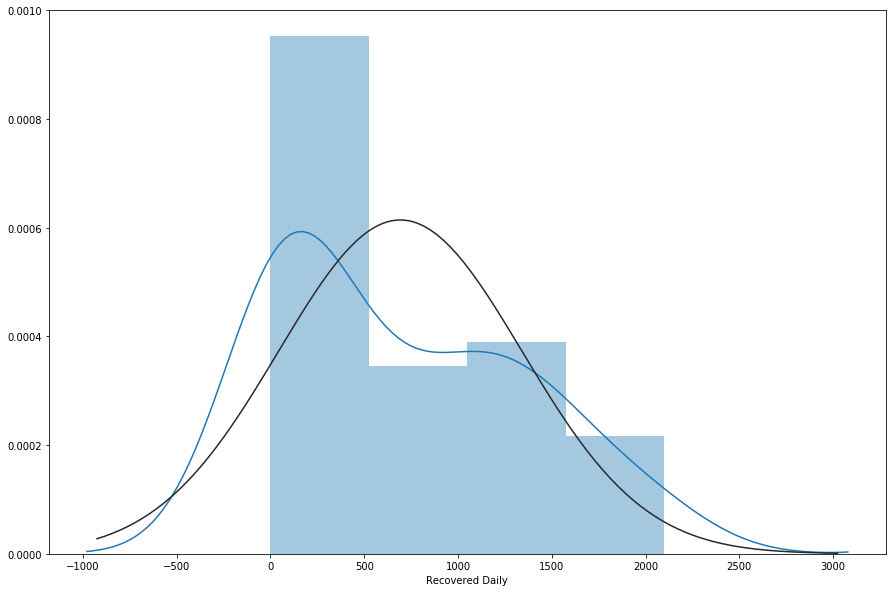

In [65]:
from scipy.stats import norm

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataframe_new['Recovered Daily'], fit=norm)

In [66]:
# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

print(pct_90)

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

40


In [67]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [68]:
regressor = LinearRegression(normalize=True)  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [69]:
y_pred = regressor.predict(X_test)


In [70]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,1555.0,449.102410
1,2099.0,932.865203
2,1979.0,617.979779
3,1985.0,-1071.591475


In [71]:
print('Mean Absolute Error:',  "%.2f" % (metrics.mean_absolute_error(y_test, y_pred),))  
print('Mean Squared Error:', "%.2f" % (metrics.mean_squared_error(y_test, y_pred),) )  
print('Root Mean Squared Error:', "%.2f" % (np.sqrt(metrics.mean_squared_error(y_test, y_pred),)))

Mean Absolute Error: 1672.41
Mean Squared Error: 3444501.83
Root Mean Squared Error: 1855.94


In [72]:
regressor.coef_

array([ 0.05183111,  0.29749919, -0.48764366, -0.05059601,  0.37824929,
       -0.23236454, -0.1047322 , -0.09057763,  0.36265339,  0.06604587,
        0.03319187, -0.21103011,  0.31654272, -0.05264126, -0.38850025])

In [73]:
print("R^2 Score: ","%.3f" % (regressor.score(X_test, y_test),) )

R^2 Score:  -79.100


In [74]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.051831
Infected cases t-8,0.297499
Infected cases t-9,-0.487644
Infected cases t-10,-0.050596
Infected cases t-11,0.378249
Infected cases t-12,-0.232365
Infected cases t-13,-0.104732
Infected cases t-14,-0.090578
Infected cases t-15,0.362653
Infected cases t-16,0.066046


### Plot coefficients (distribution of gamma)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


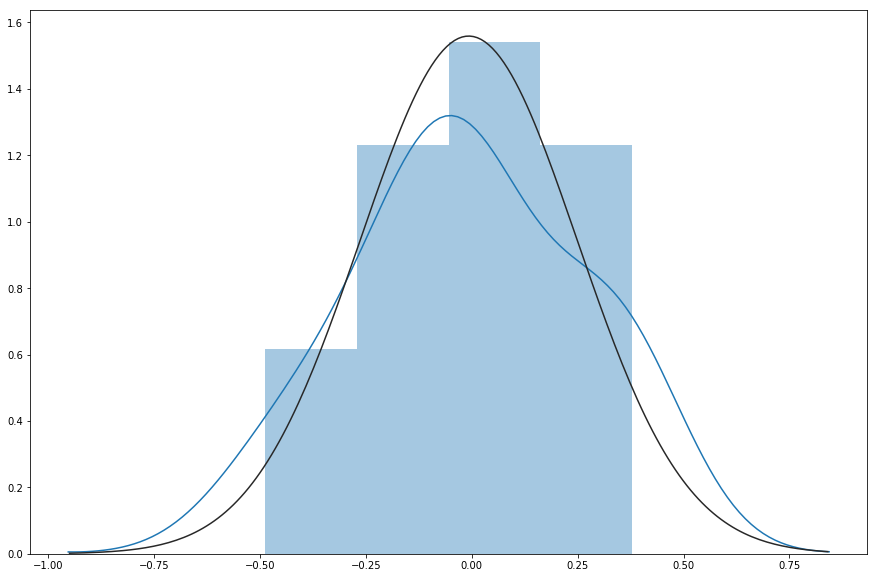

In [75]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(coeff_df, fit=norm)

**Update this**

For a unit increase in the number of recovered individuals at time t, that means there is:
- An increase of 21 infected at day t-20
- A decrease of 13 infected at day t-18

We see that the closer we are to the recovery date, the lower the number of infected cases has an impact on the number od recovered cases 

### Plot Actual values (y test) versus predicted values

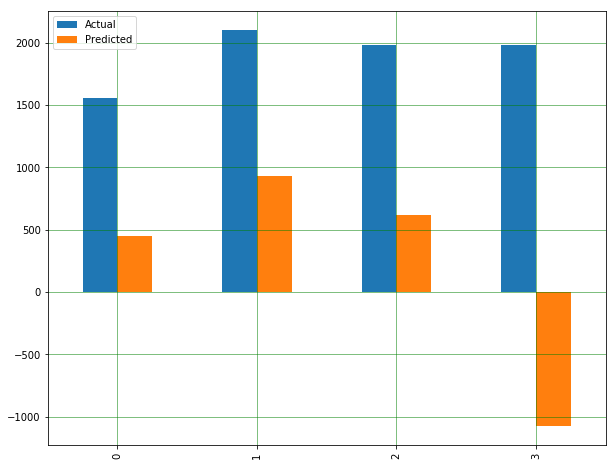

In [76]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

There are many factors that may have contributed to this inaccuracy, for example :

- **Need more data**: We need to have a huge amount of data to get the best possible prediction.
- **Bad assumptions**: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help us determine that.
- **Poor features**: The features we used may not have had a high enough correlation to the values we were trying to predict.

#  ridge regression (L2)

In [77]:
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)


In [78]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

print(pct_90)

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

40


In [79]:
# Create ridge regression with three possible alpha values

clf = Ridge(alpha=1, normalize=True)
# Fit the linear regression
model = clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

In [80]:
clf.score(X_test, y_test)

-2.447908261941411

In [81]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 342.7108957957342
Mean Squared Error: 148269.53701120103
Root Mean Squared Error: 385.0578359301379


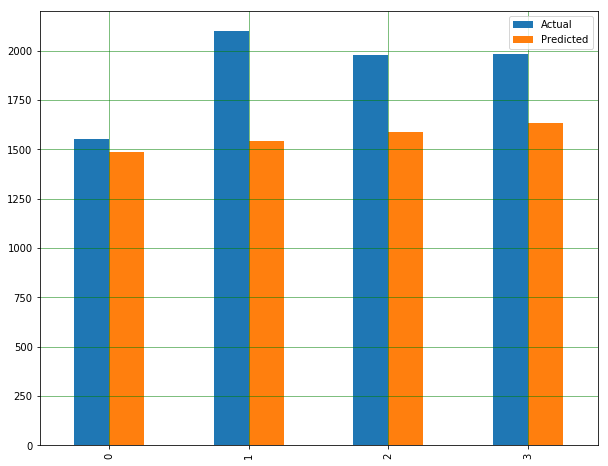

In [82]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#  Lasso Regression (L1)

In [83]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]


clf = linear_model.Lasso(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


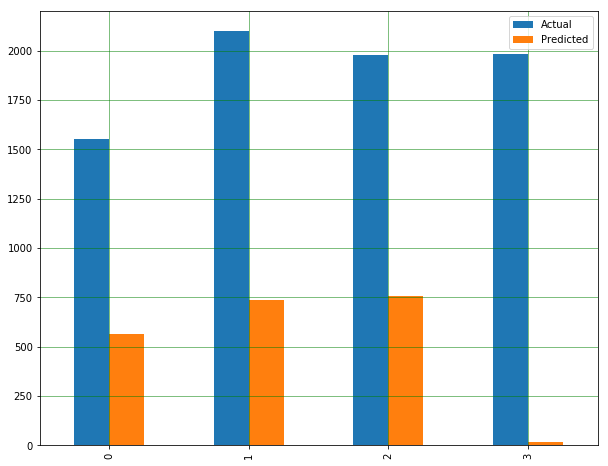

In [84]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [85]:
clf.score(X_test, y_test)

-46.608531401245756

# Linear Elastic Net regression 
(Linear regression with combined L1 and L2 priors as regularizer)

The elastic net method overcomes the limitations of the LASSO (least absolute shrinkage and selection operator) method which uses a penalty function based on

$$||\beta||_1=\sum_{j=1}^p{|\beta_j|}$$

The parameters for the elastic net method are defined by

$$\hat{\beta}\equiv \text{argmin}_{\beta}(||y-X\beta||^2+\lambda_2||\beta||^2+\lambda_1||\beta||_1)$$

In our case here, $\lambda_1=\lambda_2=\alpha$

In [98]:
y = dataframe_new['Recovered Daily'].values
X = dataframe_new.iloc[:,1:].values

#-----#

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

X_train, X_test = X[:pct_90], X[pct_90:]
y_train, y_test =y[:pct_90], y[pct_90:]


#-----#

clf = linear_model.ElasticNet(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [99]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,1555,566.353778
1,2099,738.551914
2,1979,756.599871
3,1985,18.606392


In [100]:
clf.score(X_test, y_test)

-46.60861947928985

In [101]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1384.4720114140803
Mean Squared Error: 2047301.5613130317
Root Mean Squared Error: 1430.8394603564132


In [102]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.051831
Infected cases t-8,0.297499
Infected cases t-9,-0.487644
Infected cases t-10,-0.050596
Infected cases t-11,0.378249
Infected cases t-12,-0.232365
Infected cases t-13,-0.104732
Infected cases t-14,-0.090578
Infected cases t-15,0.362653
Infected cases t-16,0.066046


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


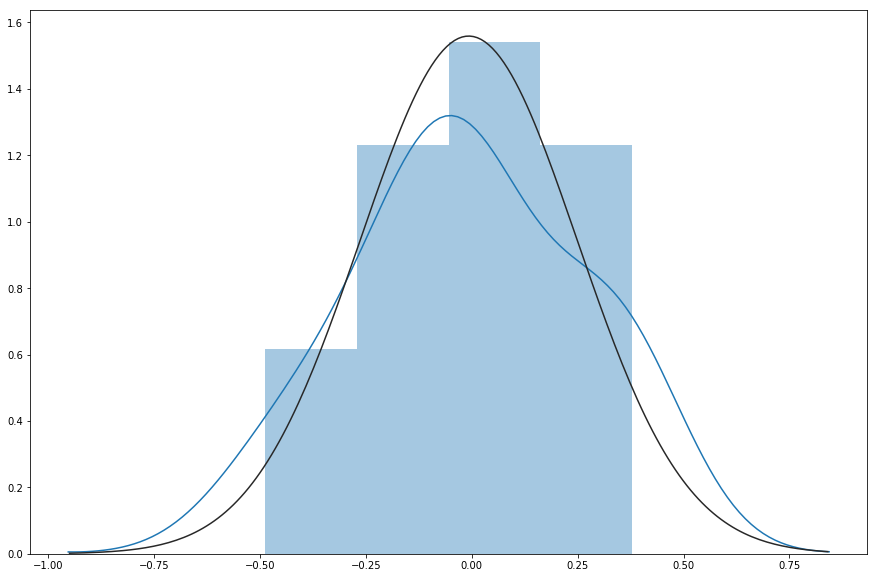

In [103]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(coeff_df, fit=norm)

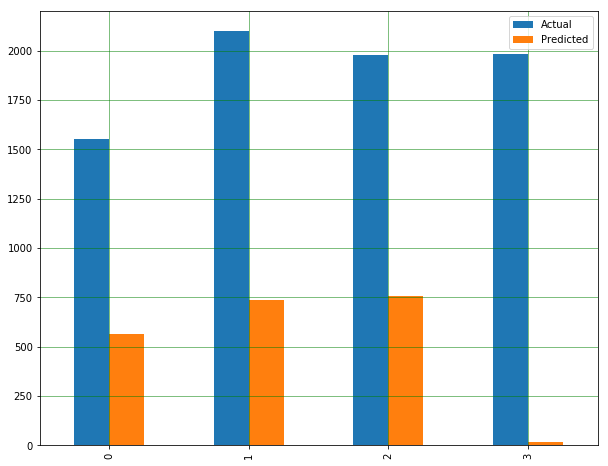

In [104]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Laplacian

### Labeled Data

In [429]:
dataframe_new = dataframe.iloc[15:,:]

In [430]:
yl = dataframe_new['Recovered cases'].values
Xl = dataframe_new.iloc[:,1:].values

### Unlabeled Data

In [438]:
Xu = unsupervised_df.iloc[:,1:].values

In [447]:
X = dataframe_new + unsupervised_df

In [451]:
unsupervised_df = unsupervised_df.set_index('Date')

In [460]:
one = pd.DataFrame(Xu)
two = pd.DataFrame(Xl)

In [464]:
X = pd.concat([two, one], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

### Algorithm

In [440]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg,random
from sklearn.base import BaseEstimator
from sklearn import datasets,metrics

class LRRidge(BaseEstimator):
    def __init__(self,alpha=1.,beta=1.,gamma=10.,k=10):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.k=k

    def fit(self,Xl,yl,Xu):
        self.X=np.r_[Xl,Xu]
        #self.X=self.X[random.permutation(len(self.X))]
        self.X2=np.c_[np.sum(self.X**2,1)]
        Xl2=np.c_[np.sum(Xl**2,1)]
        Xu2=np.c_[np.sum(Xu**2,1)]
        Phil=np.exp(-self.gamma*(Xl2+self.X2.T-2*Xl.dot(self.X.T)))
        Phiu=np.exp(-self.gamma*(Xu2+self.X2.T-2*Xu.dot(self.X.T)))

        Phiu2=np.c_[np.sum(Phiu**2,1)]
        d=Phiu2+Phiu2.T-2*Phiu.dot(Phiu.T)
        p=np.c_[np.sort(d,axis=1)[:,self.k+1]]
        W=d<=p
        W=(W+W.T)!=0
        D=np.diag(np.sum(W,axis=1))
        L=D-W
        
        n_features=Phil.shape[1]
        self.theta=linalg.pinv(Phil.T.dot(Phil)+self.alpha*np.identity(n_features)+self.beta*Phiu.T.dot(L).dot(Phiu)).dot(Phil.T).dot(yl)

        return self

    def predict(self,X):
        X2=np.c_[np.sum(X**2,1)]
        Phi=np.exp(-self.gamma*(X2+self.X2.T-2*X.dot(self.X.T)))
        return (Phi.dot(self.theta)>=0)*2-1



In [446]:
Xu + Xl

ValueError: operands could not be broadcast together with shapes (14,15) (44,15) 

In [443]:
Xl.shape

(44, 15)

### Implementation

In [469]:
clf=LRRidge().fit(Xl,yl,Xu)
ypred=clf.predict(X)
yupred=clf.predict(Xu)

print("Accuracy (LRRidge):" + metrics.accuracy_score(yu,yupred))

from sklearn.linear_model import RidgeClassifierCV
gamma=10.
X2=np.c_[np.sum(X**2,1)]
Phi=np.exp(-gamma*(X2+X2.T-2*X.dot(X.T)))
clf=RidgeClassifierCV().fit(Phi[il],yl)
yupred2=clf.predict(Phi[iu])
print("Accuracy (Ridge):" + metrics.accuracy_score(yu,yupred2))

colors=np.array(["r","b"])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(Xu[:,0],Xu[:,1],c="w",s=20)
plt.scatter(Xl[:,0],Xl[:,1],color=colors[(1+yl)/2],s=100)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1],color=colors[(1+ypred)/2])
plt.tight_layout()
plt.show()


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

- try log values
- didn't try laplacian bc w ridge parameters achieve gaussian distribution which is what we want